In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/starteredamodel/startereda_cutmix_mixup.h5
/kaggle/input/starteredamodel/startereda.h5
/kaggle/input/kalpurush-fonts/kalpurush-2.ttf


In [2]:
train_df_ = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
test_df_ = pd.read_csv('/kaggle/input/bengaliai-cv19/test.csv')
class_map_df = pd.read_csv('/kaggle/input/bengaliai-cv19/class_map.csv')
sample_sub_df = pd.read_csv('/kaggle/input/bengaliai-cv19/sample_submission.csv')

In [3]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [4]:
test_df_.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [5]:
sample_sub_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


In [6]:
class_map_df.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [7]:
print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


## Exploratory Data Analysis
Exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods.

In [8]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('/kaggle/input/kalpurush-fonts/kalpurush-2.ttf', 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

### Number of unique values

In [9]:
print(f'Number of unique grapheme roots: {train_df_["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_df_["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_df_["consonant_diacritic"].nunique()}')

Number of unique grapheme roots: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7


### Most used top 10 Grapheme Roots in training set

In [10]:
top_10_roots = get_n(train_df_, 'grapheme_root', 10)
top_10_roots

,index,component,count
72,72,দ,5736
64,64,ত,5596
13,13,ক,5420
107,107,ব,5321
23,23,গ,5149
96,96,প,4926
113,113,ভ,4395
147,147,স,4392
133,133,শ,4374
115,115,ম,4015


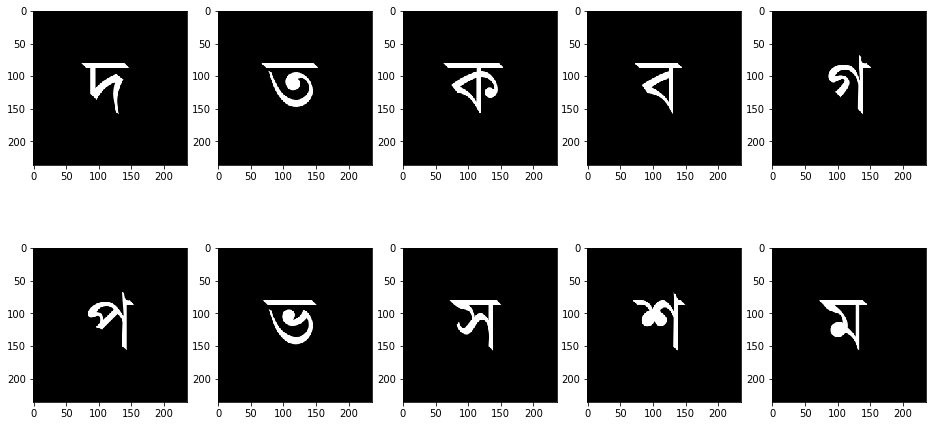

In [11]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(top_10_roots['component'].iloc[i]), cmap='Greys')

### Least used 10 Grapheme Roots in training set

In [12]:
bottom_10_roots = get_n(train_df_, 'grapheme_root', 10, False)
bottom_10_roots

,index,component,count
73,73,দ্ঘ,130
33,33,ঙ্ক্ত,136
102,102,প্স,141
158,158,স্স,143
45,45,জ্জ্ব,144
130,130,ল্ব,144
1,1,ঃ,145
12,12,ঔ,146
0,0,ং,147
63,63,ণ্ণ,149


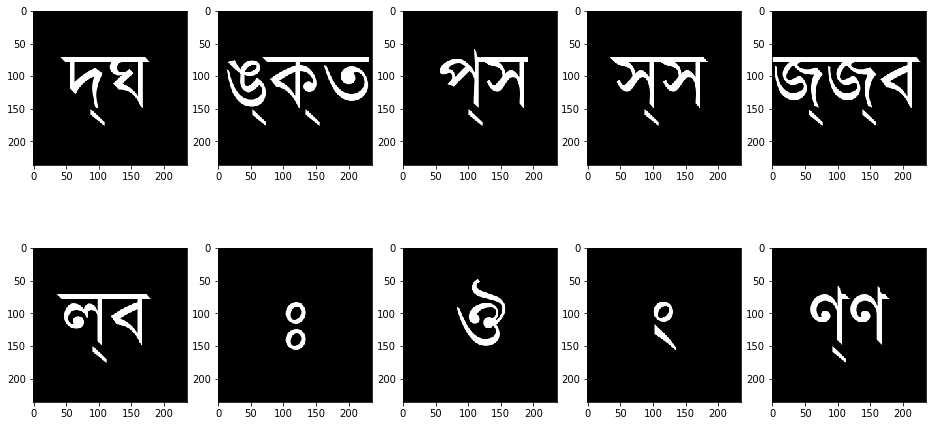

In [13]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(bottom_10_roots['component'].iloc[i]), cmap='Greys')

### Top 5 Vowel Diacritic in taining data

In [14]:
top_5_vowels = get_n(train_df_, 'vowel_diacritic', 5)
top_5_vowels

,index,component,count
0,168,0,41508
1,169,া,36886
7,175,ে,28723
2,170,ি,25967
4,172,ু,18848


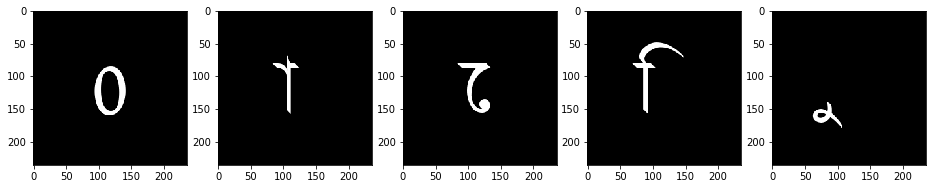

In [15]:
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_vowels['component'].iloc[i]), cmap='Greys')

### Top 5 Consonant Diacritic in training data

In [16]:
top_5_consonants = get_n(train_df_, 'consonant_diacritic', 5)
top_5_consonants

,index,component,count
0,179,0,125278
2,181,র্,23465
5,184,্র,21397
4,183,্য,21270
1,180,ঁ,7424


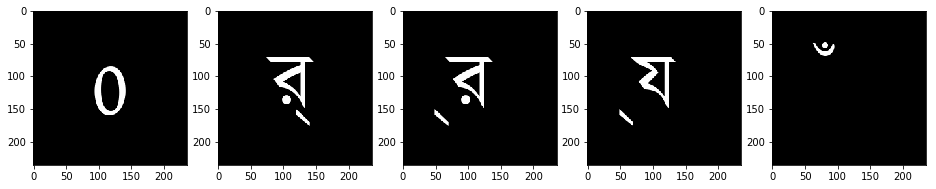

In [17]:
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_consonants['component'].iloc[i]), cmap='Greys')

In [18]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

In [19]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [20]:
IMG_SIZE=64
N_CHANNELS=1

Let's apply some image processing (credits: [this kernel](https://www.kaggle.com/shawon10/bangla-graphemes-image-processing-deep-cnn)) while resizing the images, which will center crop the region of interest from the original images.

In [21]:
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [22]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

## Basic Model

In [23]:
inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_2[0][0]                   
____________________________________________________________________________________________

Let's visualize the 3-tailed (3 output) CNN by plotting it.

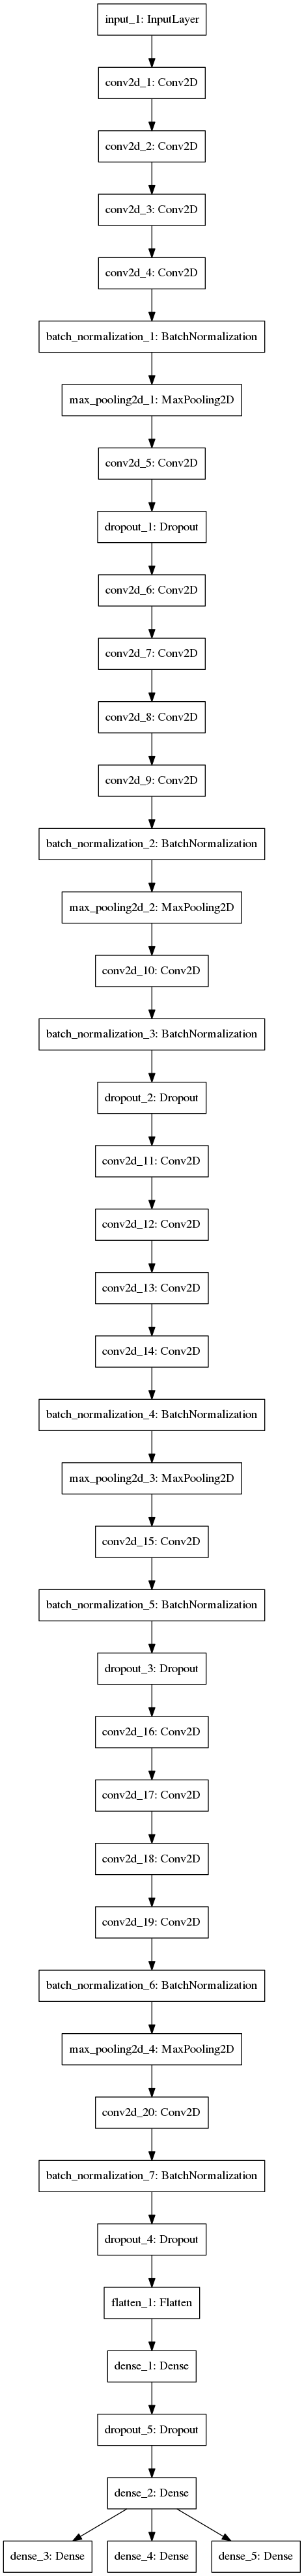

In [25]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [28]:
batch_size = 256
epochs = 30

In [29]:
# class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

#     def flow(self,
#              x,
#              y=None,
#              batch_size=32,
#              shuffle=True,
#              sample_weight=None,
#              seed=None,
#              save_to_dir=None,
#              save_prefix='',
#              save_format='png',
#              subset=None):

#         targets = None
#         target_lengths = {}
#         ordered_outputs = []
#         for output, target in y.items():
#             if targets is None:
#                 targets = target
#             else:
#                 targets = np.concatenate((targets, target), axis=1)
#             target_lengths[output] = target.shape[1]
#             ordered_outputs.append(output)


#         for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
#                                          shuffle=shuffle):
#             target_dict = {}
#             i = 0
#             for output in ordered_outputs:
#                 target_length = target_lengths[output]
#                 target_dict[output] = flowy[:, i: i + target_length]
#                 i += target_length

#             yield flowx, target_dict

### Custom Image Generator with Mixup & Cutmix
Basically you inherit the keras' ImageDataGenerator and add some augumentation functions within its class. Here I tried to implement both mixup and cutmix, and let either of them happen in a probabilistic manner. One difficulty here is that we need to have multi-outputs (actually three: 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic'), which needs to be dealt with by passing a dictionary of those.

In [30]:
# helper for mixup
def get_rand_bbox(width, height, l):
    r_x = np.random.randint(width)
    r_y = np.random.randint(height)
    r_l = np.sqrt(1 - l)
    r_w = np.int(width * r_l)
    r_h = np.int(height * r_l)
    return r_x, r_y, r_l, r_w, r_h

# custom image data generator
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):
    # custom image generator
    def __init__(self, featurewise_center = False, samplewise_center = False, 
                 featurewise_std_normalization = False, samplewise_std_normalization = False, 
                 zca_whitening = False, zca_epsilon = 1e-06, rotation_range = 0.0, width_shift_range = 0.0, 
                 height_shift_range = 0.0, brightness_range = None, shear_range = 0.0, zoom_range = 0.0, 
                 channel_shift_range = 0.0, fill_mode = 'nearest', cval = 0.0, horizontal_flip = False, 
                 vertical_flip = False, rescale = None, preprocessing_function = None, data_format = None, validation_split = 0.0, 
                 mix_up_alpha = 0.0, cutmix_alpha = 0.0): # additional class argument
    
        # parent's constructor
        super().__init__(featurewise_center, samplewise_center, featurewise_std_normalization, samplewise_std_normalization, 
                         zca_whitening, zca_epsilon, rotation_range, width_shift_range, height_shift_range, brightness_range, 
                         shear_range, zoom_range, channel_shift_range, fill_mode, cval, horizontal_flip, vertical_flip, rescale, 
                         preprocessing_function, data_format, validation_split)
        
        # Mix-up
        assert mix_up_alpha >= 0.0
        self.mix_up_alpha = mix_up_alpha
        
        # Cutmix
        assert cutmix_alpha >= 0.0
        self.cutmix_alpha = cutmix_alpha          

    def mix_up(self, X1, y1, X2, y2, ordered_outputs, target_lengths):
        assert X1.shape[0] == y1.shape[0] == X2.shape[0] == y2.shape[0]
        batch_size = X1.shape[0]
        l = np.random.beta(self.mix_up_alpha, self.mix_up_alpha, batch_size)
        X_l = l.reshape(batch_size, 1, 1, 1)
        y_l = l.reshape(batch_size, 1)
        X = X1 * X_l + X2 * (1-X_l)
        target_dict = {}
        i = 0
        for output in ordered_outputs:
            target_length = target_lengths[output]
            target_dict[output] = y1[:, i: i + target_length] * y_l + y2[:, i: i + target_length] * (1 - y_l)
            i += target_length
        y = None
        for output, target in target_dict.items():
            if y is None:
                y = target
            else:
                y = np.concatenate((y, target), axis=1)
        return X, y
    
    def cutmix(self, X1, y1, X2, y2, ordered_outputs, target_lengths):
        assert X1.shape[0] == y1.shape[0] == X2.shape[0] == y2.shape[0]
        lam = np.random.beta(self.cutmix_alpha, self.cutmix_alpha)
        width = X1.shape[1]
        height = X1.shape[0]
        r_x, r_y, r_l, r_w, r_h = get_rand_bbox(width, height, lam)
        bx1 = np.clip(r_x - r_w // 2, 0, width)
        by1 = np.clip(r_y - r_h // 2, 0, height)
        bx2 = np.clip(r_x + r_w // 2, 0, width)
        by2 = np.clip(r_y + r_h // 2, 0, height)
        X1[:, bx1:bx2, by1:by2, :] = X2[:, bx1:bx2, by1:by2, :]
        X = X1
        target_dict = {}
        i = 0
        for output in ordered_outputs:
            target_length = target_lengths[output]
            target_dict[output] = y1[:, i: i + target_length] * lam + y2[:, i: i + target_length] * (1 - lam)
            i += target_length
        y = None
        for output, target in target_dict.items():
            if y is None:
                y = target
            else:
                y = np.concatenate((y, target), axis=1)
        return X, y
    
    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):
        
        # for multi-outputs
        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)
        
        # parent flow
        batches = super().flow(x, targets, batch_size, shuffle, sample_weight, seed, save_to_dir, save_prefix, save_format, subset)
        
        # custom processing
        while True:
            batch_x, batch_y = next(batches)
            
            # mixup or cutmix
            if (self.mix_up_alpha > 0) & (self.cutmix_alpha > 0):
                while True:
                    batch_x_2, batch_y_2 = next(batches)
                    m1, m2 = batch_x.shape[0], batch_x_2.shape[0]
                    if m1 < m2:
                        batch_x_2 = batch_x_2[:m1]
                        batch_y_2 = batch_y_2[:m1]
                        break
                    elif m1 == m2:
                        break
                if np.random.rand() < 0.5:
                    batch_x, batch_y = self.mix_up(batch_x, batch_y, batch_x_2, batch_y_2, ordered_outputs, target_lengths)
                else:
                    batch_x, batch_y = self.cutmix(batch_x, batch_y, batch_x_2, batch_y_2, ordered_outputs, target_lengths)
            
                target_dict = {}
                i = 0
                for output in ordered_outputs:
                    target_length = target_lengths[output]
                    target_dict[output] = batch_y[:, i: i + target_length]
                    i += target_length
                    
                yield batch_x, target_dict

In [31]:
HEIGHT = 137
WIDTH = 236

**Test cutmix & mixup**

In [32]:
# show images
def show_imgs(imgs, row, col):
    if len(imgs) != (row * col):
        raise ValueError("Invalid imgs len:{} col:{} row:{}".format(len(imgs), row, col))

    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, img in enumerate(imgs):
        plot_num = i+1
        ax = fig.add_subplot(row, col, plot_num, xticks=[], yticks=[])
        ax.imshow(img)
    plt.show()

# let's have a look if our custom ImageDataGenerator works fine
max_img_num = 12

### Training loop

In [33]:
# histories = []
# for i in range(4):
#     train_df = pd.merge(pd.read_parquet(f'/kaggle/input/bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
#     # Visualize few samples of current training dataset
#     fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
#     count=0
#     for row in ax:
#         for col in row:
#             col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
#             count += 1
#     plt.show()
    
#     X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
#     X_train = resize(X_train)/255
    
#     # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
#     X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
#     Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
#     Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
#     Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

#     print(f'Training images: {X_train.shape}')
#     print(f'Training labels root: {Y_train_root.shape}')
#     print(f'Training labels vowel: {Y_train_vowel.shape}')
#     print(f'Training labels consonants: {Y_train_consonant.shape}')

#     # Divide the data into training and validation set
#     x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
#     del train_df
#     del X_train
#     del Y_train_root, Y_train_vowel, Y_train_consonant

#     # Data augmentation for creating more training data
#     datagen = MultiOutputDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range= 16,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.15, # Randomly zoom image 
#         width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
#         mix_up_alpha = 0.4, 
#         cutmix_alpha = 0.4, 
#         horizontal_flip=False,  # randomly flip images
#         vertical_flip=False)  # randomly flip images


#     # This will just calculate parameters required to augment the given data. This won't perform any augmentations
#     datagen.fit(x_train)
    
#     imgs = []
#     for d in datagen.flow(x_train, {'dense_3': y_train_root, 'dense_4': y_train_vowel, 'dense_5': y_train_consonant}, batch_size=64):
#         # note that target_size = (height, width)
#         imgs.append(np.squeeze(d[0][0, :, :, 0].reshape(-1).reshape(1, IMG_SIZE, IMG_SIZE).astype(np.float64), axis=0))
#         if (len(imgs) % max_img_num) == 0:
#             break
#     show_imgs(imgs, row=3, col=4)
#     del imgs

#     # Fit the model
#     history = model.fit_generator(datagen.flow(x_train, {'dense_3': y_train_root, 'dense_4': y_train_vowel, 'dense_5': y_train_consonant}, batch_size=batch_size),
#                               epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
#                               steps_per_epoch=x_train.shape[0] // batch_size, 
#                               callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

#     histories.append(history)
    
#     # Delete to reduce memory usage
#     del x_train
#     del x_test
#     del y_train_root
#     del y_test_root
#     del y_train_vowel
#     del y_test_vowel
#     del y_train_consonant
#     del y_test_consonant
#     gc.collect()

In [34]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_3_loss'], label='train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_4_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_5_loss'], label='train_consonant_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_loss'], label='val_train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_loss'], label='val_train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_loss'], label='val_train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['dense_3_accuracy'], label='train_root_acc')
    plt.plot(np.arange(0, epoch), his.history['dense_4_accuracy'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['dense_5_accuracy'], label='train_consonant_accuracy')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_accuracy'], label='val_root_acc')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_accuracy'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_accuracy'], label='val_consonant_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

In [35]:
for dataset in range(4):
    plot_loss(histories[dataset], epochs, f'Training Dataset: {dataset}')
    plot_acc(histories[dataset], epochs, f'Training Dataset: {dataset}')

NameError: name 'histories' is not defined

In [36]:
del histories
gc.collect()

NameError: name 'histories' is not defined

In [37]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [38]:
from keras.models import load_model
model = load_model("/kaggle/input/starteredamodel/startereda_cutmix_mixup.h5")

In [39]:
components = ['grapheme_root',  'vowel_diacritic', 'consonant_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet('/kaggle/input/bengaliai-cv19/test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head()

,row_id,target
0,Test_0_grapheme_root,3
1,Test_0_vowel_diacritic,0
2,Test_0_consonant_diacritic,0
3,Test_1_grapheme_root,93
4,Test_1_vowel_diacritic,2


In [40]:
# model.save("startereda.h5")